In [1]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
BQ_LOCATION = 'US'
REGION = 'us-west3'

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd

In [4]:
GCS_BUCKET = f"{PROJECT_ID}-lukes_capstone"
#Make Bucket command, only needs to be run once
# !gsutil mb -l $REGION gs://$GCS_BUCKET     #Make Bucket command, only needs to be run once

In [5]:
BQ_DATASET = f"{PROJECT_ID}:luke_cap_data"
#Make Dataset command, only needs to be run once
# !bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

In [6]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

# Pull in MAIN QUERY HERE

## Creat ML_Features Table

#### Try this, with nulls cast to 0 or "Unknown", and set model option class weight = auto

In [7]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.final_features AS (

SELECT 
    DISTINCT(CONCAT(fullVisitorId,visitId,hits.hitNumber)) AS User_session,
    IFNULL(trafficSource.source,"Unknown") AS source, 
    IFNULL(trafficSource.medium,"Unknown") AS medium, 
    IFNULL(device.browser,"Unknown") AS browser, 
    IFNULL(device.operatingSystem,"Unknown") AS os, 
    IFNULL(device.deviceCategory,"Unknown") AS deviceType,
    IFNULL(geoNetwork.country,"Unknown") AS country, 
    IFNULL(IF(geoNetwork.region='not available in demo dataset',NULL,geoNetwork.region),"Unknown") AS region, 
    IFNULL(IF(geoNetwork.metro='not available in demo dataset',NULL,geoNetwork.metro),"Unknown") AS metro, 
    IFNULL(IF(geoNetwork.city='not available in demo dataset',NULL,geoNetwork.city),"Unknown") AS city, 
    IFNULL(geoNetwork.networkDomain,"Unknown") AS domain,
    IFNULL(hits.type,"Unknown") AS hitType,
    IFNULL(product.v2ProductCategory,"Unknown") AS productCategory,
    IFNULL(channelGrouping,"Unknown") AS channelGrouping,
    IFNULL(visitNumber,0) AS visitNumber,
    IFNULL(totals.pageviews,0) AS pageviews, 
    IFNULL(totals.timeOnSite,0) AS timeOnSite, 
    IFNULL(hits.hitNumber,0) AS hitNumber, 
    IFNULL(hits.time,0) AS time, 
    IFNULL(hits.hour,0) AS hour, 
    # if(hits.eventInfo.eventAction = 'Add to cart',1,0) AS Target
    if(hits.eCommerceAction.action_type = '3',1,0) AS Target,


    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT((CONCAT(fullVisitorId,visitId,hits.hitNumber))), 10)) <= 7
        THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT((CONCAT(fullVisitorId,visitId,hits.hitNumber))), 10)) = 8
        THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT((CONCAT(fullVisitorId,visitId,hits.hitNumber))), 10)) = 9
        THEN 'TEST'    
          ELSE '' END AS data_split
    
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*` final, 
UNNEST(hits) AS hits LEFT JOIN UNNEST(hits.product) AS product
WHERE hits.eCommerceAction.action_type != '0'

);

Query is running:   0%|          |

""


### CHECK DATA SPLITS

In [8]:
%%bigquery --project $PROJECT_ID

SELECT
  data_split,
  COUNT(*) AS n_examples
FROM luke_cap_data.final_features
GROUP BY data_split

Query is running:   0%|          |

Downloading:   0%|          |

,data_split,n_examples
0,EVAL,6556
1,TRAIN,53166
2,TEST,6755


# BUILD/TRAIN MODEL
## XGBoost:  Boosted Tree Model

In [9]:
MODEL_NAME="Luke_cap"

In [10]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL luke_cap_data.Luke_cap

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["Target"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  AUTO_CLASS_WEIGHTS = True,
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MIN_TREE_CHILD_WEIGHT = HPARAM_RANGE(0, 5),
  COLSAMPLE_BYTREE = HPARAM_RANGE(0.7, 1.0),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([4,5,6,7])
) AS

SELECT
  * EXCEPT(User_session)
FROM
  luke_cap_data.final_features

Query is running:   0%|          |

""


### Display model trial results

In [11]:
%%bigquery --project $PROJECT_ID

SELECT *
FROM
  ML.TRIAL_INFO(MODEL `luke_cap_data.Luke_cap`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6, 'min_...",{'roc_auc': 0.902090909090909},0.379296,0.386203,SUCCEEDED,None,False
1,2,"{'learn_rate': 0.0813994538610966, 'max_tree_d...",{'roc_auc': 0.9025884115884116},0.395991,0.402062,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.08024079102257872, 'max_tree_...",{'roc_auc': 0.8952547452547452},0.404637,0.408472,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.06024888978366152, 'max_tree_...",{'roc_auc': 0.9028591408591409},0.425134,0.432442,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.037929616988277945, 'max_tree...",{'roc_auc': 0.8901918081918082},0.478586,0.481775,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.1, 'max_tree_depth': 6, 'min_...",{'roc_auc': 0.9032797202797203},0.379926,0.387528,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.0358017398433325, 'max_tree_d...",{'roc_auc': 0.902008991008991},0.491083,0.496878,SUCCEEDED,None,False
7,8,"{'learn_rate': 0.06132854493292612, 'max_tree_...",{'roc_auc': 0.9062657342657343},0.434571,0.443349,SUCCEEDED,None,True


## EVALUATE MODEL PERFORMANCE

### BEST MODEL PERFORMANCE for 8th trial

In [12]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL luke_cap_data.Luke_cap)
WHERE trial_id=8;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,8,0.272411,0.971074,0.718135,0.425468,0.450165,0.914231


### CREATE CONFUSION MATRIX

In [18]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL luke_cap_data.Luke_cap)
WHERE trial_id=8;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,4146,1883
1,1,21,705


### ROC CURVE: Create Dataframe (df_roc) to plot ROC Curve

In [14]:
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL luke_cap_data.Luke_cap)

Query is running:   0%|          |

Downloading:   0%|          |

### PLOT ROC Curve

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

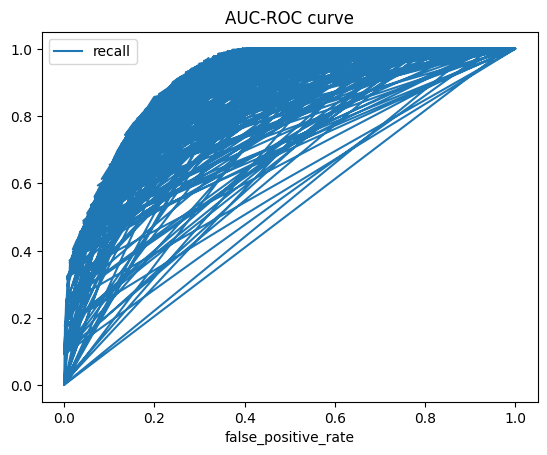

In [15]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

### CHECK GLOBAL FEATURE CONTRIBUTIONS

In [16]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL luke_cap_data.Luke_cap)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,8,hitType,0.409846
1,8,productCategory,0.139229
2,8,hitNumber,0.047257
3,8,pageviews,0.035154
4,8,visitNumber,0.020921
5,8,timeOnSite,0.019009
6,8,channelGrouping,0.013919
7,8,country,0.010992
8,8,time,0.006358
9,8,deviceType,0.006013


#### SOME SAMPLE TEST SET PREDICTIONS

In [17]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL luke_cap_data.Luke_cap,
  (SELECT * FROM luke_cap_data.final_features WHERE data_split = "TEST" LIMIT 5))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_Target,predicted_Target_probs,User_session,source,medium,browser,os,deviceType,country,...,productCategory,channelGrouping,visitNumber,pageviews,timeOnSite,hitNumber,time,hour,Target,data_split
0,8,0,"[{'label': 1, 'prob': 0.21103814244270325}, {'...",762304050806321885714866722183,google,cpc,Chrome,Chrome OS,desktop,United States,...,Home/Bags/Backpacks/,Paid Search,1,4,45,3,30748,12,0,TEST
1,8,1,"[{'label': 1, 'prob': 0.562504231929779}, {'la...",572321380260428269114866639134,(direct),(none),Chrome,Macintosh,desktop,United States,...,Home/Apparel/Kid's/Kid's-Infant/,Direct,2,3,25,4,24961,10,0,TEST
2,8,0,"[{'label': 1, 'prob': 0.18027454614639282}, {'...",675548896210347275114866797634,(direct),(none),Chrome,Macintosh,desktop,United States,...,Home/Apparel/Women's/Women's-Performance Wear/,Referral,5,4,124,4,124032,14,0,TEST
3,8,0,"[{'label': 1, 'prob': 0.44307541847229004}, {'...",419032739446526298814866509884,qiita.com,referral,Safari,iOS,mobile,Japan,...,Home/Apparel/Men's/,Referral,1,4,69,4,55928,6,0,TEST
4,8,0,"[{'label': 1, 'prob': 0.46201953291893005}, {'...",419032739446526298814866509885,qiita.com,referral,Safari,iOS,mobile,Japan,...,Home/Apparel/Men's/,Referral,1,4,69,5,68615,6,0,TEST


#### Create a dataframe of model predictions for entire set

In [19]:
%%bigquery df_test_preds --project $PROJECT_ID

SELECT 
  User_session,
  Target,
  predicted_Target,
  predicted_Target_probs as probability_Target
FROM
  ML.PREDICT(MODEL luke_cap_data.Luke_cap,
  (SELECT * FROM luke_cap_data.final_features))

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
print("Actual:", df_test_preds['Target'].value_counts())
print("Predicted:", df_test_preds['predicted_Target'].value_counts())

Actual: Target
0    59117
1     7360
Name: count, dtype: Int64
Predicted: predicted_Target
0    41085
1    25392
Name: count, dtype: Int64


In [21]:
df_test_preds.head()

,User_session,Target,predicted_Target,probability_Target
0,623906203994416221514872354522,0,0,"[{'label': 1, 'prob': 0.15593446791172028}, {'..."
1,807713746149558367714872399552,0,0,"[{'label': 1, 'prob': 0.198360413312912}, {'la..."
2,961553193622849742214872530822,0,0,"[{'label': 1, 'prob': 0.2139234095811844}, {'l..."
3,022764266190713996814872761732,0,0,"[{'label': 1, 'prob': 0.18765099346637726}, {'..."
4,239904212929804264414872509702,0,0,"[{'label': 1, 'prob': 0.214144766330719}, {'la..."


#### Calculate True Positives, True Negatives, False Positives, False Negatives for entire dataset

In [22]:
TP = 0
FP = 0
TN = 0
FN = 0

for index, row in df_test_preds.iterrows():
    if row["Target"] == 1 and row["predicted_Target"] == 1:
        TP += 1
    elif row["Target"] == 0 and row["predicted_Target"] == 1:
        FP += 1
    elif row["Target"] == 0 and row["predicted_Target"] == 0:
        TN += 1
    else:
        FN += 1

In [23]:
print("RECALL: ",TP/(TP+FN))
print("PRECISION: ",TP/(TP+FP))
print("True Positives: :", TP)
print("True Negatives: :", TN)
print("False Positives: :", FP)
print("False Negatives: :", FN)

RECALL:  0.9642663043478261
PRECISION:  0.27949747952110904
True Positives: : 7097
True Negatives: : 40822
False Positives: : 18295
False Negatives: : 263


#### Precision is poor, but recall is very strong.  Model is doing a good job of capturing positive value for target class but also mislabeling some 0's as 1's (False positives).

#### Create table view of test set prediction results (df_test_results)

In [24]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE TABLE luke_cap_data.Luke_cap_preds AS (
SELECT 
  User_session,
  Target,
  predicted_Target,
  predicted_Target_probs as probability_Target
FROM
  ML.PREDICT(MODEL luke_cap_data.Luke_cap,
  (SELECT * FROM luke_cap_data.final_features))
);



Query is running:   0%|          |

""


# SEND TO VERTEX AI ENDPOINT

#### Assign Name of Model & Export Path

In [25]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

#### Export model to bucket

In [26]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r414efa3dd21a0710_0000018dc4c9e980_1 ... (5s) Current status: DONE   


#### Send Model from BUCKET to VERTEX AI

#### Create latest pre-built VERTEX XBGOOST prediction container

In [27]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

#### Send model to container

In [28]:
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-west3/models/8794492133277958144/operations/3241595574171992064
Model created. Resource name: projects/319407066227/locations/us-west3/models/8794492133277958144@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-west3/models/8794492133277958144@1')


#### DEPLOY VERTEX AI EndPoint

In [29]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-west3/endpoints/7151373160636481536/operations/7853281592599379968
Endpoint created. Resource name: projects/319407066227/locations/us-west3/endpoints/7151373160636481536
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-west3/endpoints/7151373160636481536')
Deploying model to Endpoint : projects/319407066227/locations/us-west3/endpoints/7151373160636481536
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-west3/endpoints/7151373160636481536/operations/2162420513463336960
Endpoint model deployed. Resource name: projects/319407066227/locations/us-west3/endpoints/7151373160636481536


#### MAP ENCODINGS Learned by Model to user input features for Online Predictions

In [30]:
%%bigquery df_cat_features --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.final_features

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
for col in df_cat_features.columns:
    print(col,":",df_cat_features[col].dtype)

User_session : object
source : object
medium : object
browser : object
os : object
deviceType : object
country : object
region : object
metro : object
city : object
domain : object
hitType : object
productCategory : object
channelGrouping : object
visitNumber : Int64
pageviews : Int64
timeOnSite : Int64
hitNumber : Int64
time : Int64
hour : Int64
Target : Int64
data_split : object


#### Choose all categorical features except User_session and data_split

In [32]:
CAT_FEATURES = [col for col in df_cat_features.columns if (df_cat_features[col].dtype==object and col!= "User_session" and col!= "data_split")]
CAT_FEATURES

['source',
 'medium',
 'browser',
 'os',
 'deviceType',
 'country',
 'region',
 'metro',
 'city',
 'domain',
 'hitType',
 'productCategory',
 'channelGrouping']

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Map Features from model to User inputs for Online Predictions

#### Create a list of paths pointing to each encoded categorical feature stored by the model

In [34]:
CATEGORICAL_FEATURES = []
for idx, feature in enumerate(CAT_FEATURES):
    feature_vocab_file = f"gs://{GCS_BUCKET}/{MODEL_NAME}/assets/{idx}_categorical_label.txt"
    CATEGORICAL_FEATURES.append(feature_vocab_file)
print(CATEGORICAL_FEATURES)

['gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/0_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/1_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/2_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/3_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/4_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/5_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/6_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/7_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/8_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/9_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/10_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/11_categorical_label.txt', 'gs://york-bb-cohort-lukes_capstone/Luke_cap/assets/12_catego

In [35]:
 # Build categorical feature encoders for mapping text to integers for XGBoost inference. 
 #    Input a list of strings (CATEGORICAL_FEATURES) that point to encoded feature files store by the model
 #     na_value (str): default is 'Unknown'. String value to replace any vocab NaN values prior to encoding.
 #    Outputs a dictionary of encoders for each categorical feature in the model to prep user input data for the model 
 #     to make online predictions.
    

feature_encoders = {}
    
for feat in CATEGORICAL_FEATURES:
    for f in CAT_FEATURES:
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_df = pd.read_csv(feat, delimiter = "\t", header=None).fillna('Unknown')
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[f] = feature_encoder
feature_encoders  


{'source': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'medium': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'browser': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'os': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'deviceType': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'country': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'region': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'metro': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'city': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'domain': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'hitType': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'productCategory': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'channelGrouping':

In [41]:
# Transform instances to numerical values for inference.
    # Inputs a dictionary of test inputs, the original data set's categorical features and their encoders
    # Outputs a list of lists of transformed categorical features in numerical form the model can handle

def preprocess_xgboost(instances, cat_feature_list, feature_encoders):    
    transformed_instances = []
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)
    return transformed_instances

#### Generate some test data for online predictions

In [42]:
%%bigquery test_df --project $PROJECT_ID 

SELECT* EXCEPT (User_session, Target, data_split)
FROM luke_cap_data.final_features
WHERE data_split="TEST"
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

In [43]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name.
test_instances = test_df.astype(str).to_dict(orient='records')

In [44]:
# Apply preprocessing to transform categorical features and return numerical instances for prediction.
transformed_test_instances = preprocess_xgboost(test_instances, CAT_FEATURES, feature_encoders)

In [45]:
# Generate predictions from model deployed to Vertex AI Endpoint.
predictions = endpoint.predict(instances=transformed_test_instances)

In [46]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "Churn" and below "Not Churn".
    add2cart = "Added" if prediction[0] >= 0.5 else "Not Added"
    print(f"Prediction: Customer {idx} - {add2cart} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Added [0.7322972416877747, 0.267702728509903]
{"source":"(direct)","medium":"(none)","browser":"Chrome","os":"Windows","deviceType":"desktop","country":"United States","region":"Unknown","metro":"Unknown","city":"Unknown","domain":"mckinneyisd.net","hitType":"EVENT","productCategory":"Home\/Office\/Office Other\/","channelGrouping":"Direct","visitNumber":"1","pageviews":"14","timeOnSite":"1795","hitNumber":"13","time":"579397","hour":"7"}

Prediction: Customer 1 - Added [0.7188335657119751, 0.2811664640903473]
{"source":"dfa","medium":"cpm","browser":"Chrome","os":"Chrome OS","deviceType":"desktop","country":"United States","region":"New York","metro":"New York NY","city":"New York","domain":"(not set)","hitType":"EVENT","productCategory":"Home\/Office\/Notebooks & Journals\/","channelGrouping":"Display","visitNumber":"10","pageviews":"14","timeOnSite":"167","hitNumber":"6","time":"61102","hour":"6"}

Prediction: Customer 2 - Added [0.720758855342865, 0.2792411